# Attempt to pluck a guitar string
The wave equation is not derived here.

### $c^2\frac{\partial^2 w(x,t)}{\partial x^2} = \frac{\partial^2 w(x,t)}{\partial t^2}$
where $c = \sqrt{\tau/\rho A}$

A high E string when plucked has a frequency of 329.63 Hz.  

My D'Addario E string  has a diameter of 0.25mm, a tension of 7.35 kg of force.  The scale length used for the tension measurement is 648mm.  The density should be somewhere around 3.89E-4 kg/m from sleuthing on the internet.

The string is fixed at the ends, so requries boundary conditions of $w(0,t)=w(l,t)=0$

Once seperation of variables are applied ($Y(x)$ and $f(t)$) and the boundary conditions, the natrual frequencis are

## $\omega_n = \frac{n\pi c}{l}$ 
for n=1,2,3,...

The mode shapes are
$Y_n = \sin(\frac{n\pi}{l}x)$

The first natural frequency is $\omega_1 = \frac{\pi c}{l} = \frac{pi\sqrt{\tau}}{l\sqrt{\rho A}}$

Rearranging the equations, the density should be 
## $\rho = \frac{\pi^2\tau}{l^2 A \omega_1^2}$
where $A=d^2\pi/4$

The density per unit length is $\rho A$

The modal mass is $m_n=\rho A L/2$ and the modal stiffness is $k_n = m_n\omega_n^2$

In [74]:
import numpy as np
d = 0.25/1000       #mm 2 m
tau = 7.35*9.81     #kg 2 kgm/s^2
L= 648/1000        #mm 2 m
A = d**2*np.pi/4
omega1 = 329.63*2*np.pi # Hz to rad/s
rho = (np.pi/L)**2*tau/(A*omega1**2)
print(rho*A)
c = (tau/(rho*A))**0.5

0.00039508712977466727


In [75]:
(np.pi*c*10)/L

20711.26372805607

Text(0, 0.5, 'Mode 3')

<Figure size 432x288 with 0 Axes>

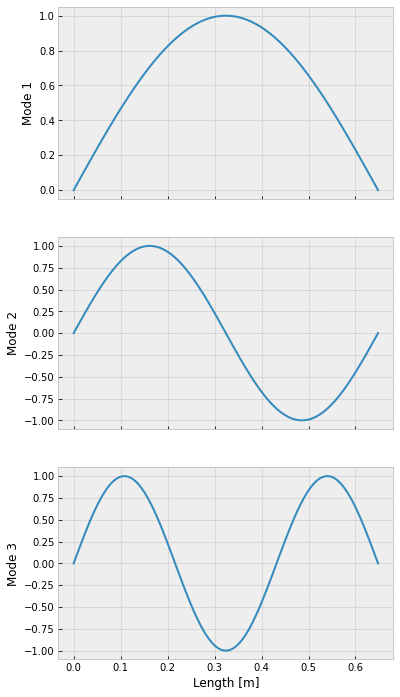

In [76]:
xarray = np.linspace(0,L,100)
narray = [1,2,3]

Ynarray = []
for n in narray:
    Yarray = [np.sin(n*np.pi/L*x) for x in xarray]
    Ynarray.append(Yarray)
    
import matplotlib.pyplot as plt 
plt.style.use('bmh')

f1 = plt.figure('Figure 1')
f1, ax = plt.subplots(3,1,sharex=True,figsize=(6,12))
ax[0].plot(xarray,Ynarray[0])
ax[0].set_ylabel('Mode 1')
ax[1].plot(xarray,Ynarray[1])
ax[1].set_ylabel('Mode 2')
ax[2].plot(xarray,Ynarray[2])
ax[2].set_xlabel('Length [m]')
ax[2].set_ylabel('Mode 3')


In [138]:
import math
from scipy import integrate

# Choose number of modes to include
modeNum = 30

# Modal Masses
m_modalArray = []
for i in range(modeNum):
    m_modalArray.append(rho*A*L/2)
    
# Modal Frequencies
wn_modalArray = []
for n in range(1,modeNum+1):
    wn_modalArray.append(c*math.pi*n/L)
    
print([wn/(2*math.pi) for wn in wn_modalArray])

# Modal Stiffnesses
k_modalArray = [m_m*w_m**2 for m_m,w_m in zip(m_modalArray,wn_modalArray)]

# Mode Shapes
Y = lambda n,x: math.sin(n*math.pi*x/L)

p0_array = [0]*modeNum
q0_array = [0]*modeNum
x0 = p0_array + q0_array

[329.63, 659.26, 988.8899999999999, 1318.52, 1648.15, 1977.7799999999997, 2307.41, 2637.04, 2966.67, 3296.3, 3625.9299999999994, 3955.5599999999995, 4285.19, 4614.82, 4944.45, 5274.08, 5603.71, 5933.34, 6262.97, 6592.6, 6922.229999999999, 7251.859999999999, 7581.489999999999, 7911.119999999999, 8240.75, 8570.38, 8900.01, 9229.64, 9559.269999999999, 9888.9]


In [143]:
# EOM and Simulation Setup
tspan = [0,.01]

# 10 times the frequncy we're expecting at least
f_max = wn_modalArray[-1]/(2*math.pi)*10*5

ntPoints = (tspan[1]-tspan[0])*f_max
ntPoints = math.ceil(ntPoints)
t = np.linspace(tspan[0],tspan[1],ntPoints)

def eom(t,x):
    p = x[0:modeNum]
    q = x[modeNum:2*(modeNum)]
    dp = []
    dq = []
    
    F=0.0
    t_impulse = 1/f_max
    # Impulse should happen 'intantanously', or, faster than the largest frequency
    tstart = 0.0
    if t>tstart and t<tstart+1/f_max:
        F=f_max
    
    for i in range(modeNum):
        dp.append(-k_modalArray[i]*q[i] + Y(i+1,L/5)*F)
        dq.append(p[i]/m_modalArray[i])
        
    dx = dp + dq
    return dx

sol = integrate.solve_ivp(eom,tspan,x0,t_eval = t,max_step = 1/f_max)

In [147]:
# Find the accelarations at a location
nPoints = 60
locations = np.linspace(0,L,nPoints+2)[1:-1]

# Need the derivatives
# Reassemble the sol.y output for parsing through EOM in a for loop
yParsed = list(zip(*sol.y))

dx = []
for i in range(len(sol.t)):
    temp = eom(sol.t[i],yParsed[i])
    dx.append(temp[0:modeNum])

y_listener = 1
cSpeed = 343
dtfun = lambda x: (y_listener**2 + x**2)**0.5/cSpeed
dtArray = [dtfun(xpos) for xpos in locations]

npadding = [math.floor(dt*f_max) for dt in dtArray]
print(npadding)

ddwArray = []
for (xpoint,pad) in zip(locations,npadding):
    ddw_point = []
    for i in range(len(sol.t)):
        a = [dx[i][j]/m_modalArray[j]*Y(j+1,xpoint) for j in range(modeNum)]
        ddw_point.append(sum(a))
    ddw_sound = [0]*pad + ddw_point[pad:]
    ddwArray.append(ddw_sound)

sound = list(map(sum, zip(*ddwArray)))

from IPython import display
display.Audio([entry/nPoints for entry in sound],rate=f_max)


[1441, 1441, 1442, 1442, 1443, 1444, 1445, 1446, 1448, 1449, 1451, 1453, 1455, 1457, 1459, 1462, 1464, 1467, 1470, 1473, 1476, 1480, 1483, 1487, 1491, 1495, 1499, 1503, 1508, 1512, 1517, 1522, 1527, 1532, 1537, 1543, 1548, 1554, 1560, 1566, 1572, 1578, 1584, 1591, 1597, 1604, 1611, 1618, 1625, 1632, 1639, 1646, 1654, 1661, 1669, 1677, 1685, 1693, 1701, 1709]


In [148]:
display.Audio([entry/nPoints for entry in ddwArray[-1]],rate=f_max)

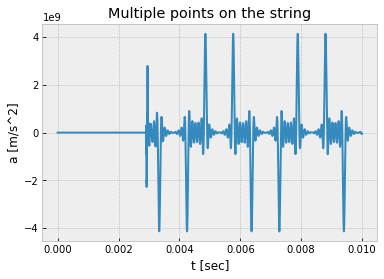

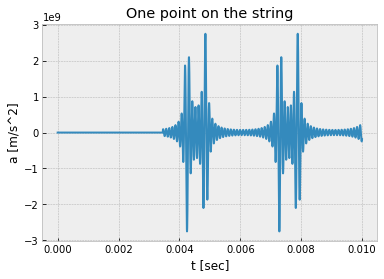

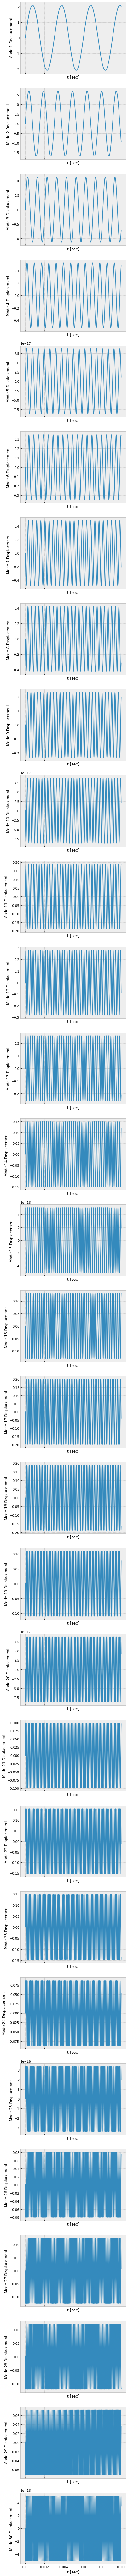

In [149]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

f1 = plt.figure('Figure 1')
plt.plot(sol.t,sound)
plt.xlabel('t [sec]')
plt.ylabel('a [m/s^2]')
plt.title('Multiple points on the string')

f2 = plt.figure('Figure 2')
plt.plot(sol.t,ddwArray[-1])
plt.xlabel('t [sec]')
plt.ylabel('a [m/s^2]')
plt.title('One point on the string')

subNum = modeNum
if subNum <2:
    subNum = 2
f3,ax = plt.subplots(subNum,1,sharex=True,figsize=(6,5*subNum))
for i in range(modeNum):
    ax[i].plot(sol.t,sol.y[i+modeNum])
    ax[i].set_xlabel('t [sec]')
    ax[i].set_ylabel('Mode {} Displacement'.format(i+1))